# Tutorial 5: NanoString CosMx SMI (NSCLC dataset)

This tutorial demonstrates how to identify subcellular distributions on the NanoString CosMx SMI platform.

In this tutorial, we foucs on the human non-small cell lung cancer (NSCLC, https://nanostring.com/resources/smi-ffpe-dataset-lung13-data/). Before running the model, please download the input data via https://zenodo.org/record/8185216/files/NSCLC.rar?download=1.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import squidpy as sq
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import time
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import train_model
from stGCL.utils import Cal_Spatial_Net,mclust_R
import anndata as ad

In [2]:
section_id="Lung13"
rad_cutoff=0
use_image=False
seed=0
set_seed(seed)
top_genes = 3000
epoch = 3000
k=12
fov="2"

In [3]:
Ann_df = pd.read_csv("/home/dell/stproject/stGCL/Data/NSCLC/cell_label_13.csv", sep=",", header=0,
                     index_col=0)
adata = sq.read.nanostring(
    path="/home/dell/stproject/stGCL/Data/NSCLC",
    counts_file="{}_exprMat_file.csv".format(section_id),
    meta_file="{}_metadata_file.csv".format(section_id),
    fov_file="{}_fov_positions_file.csv".format(section_id),
)
print(adata.shape)
adata.obs["ground_truth"]=Ann_df['ground_truth']

(82843, 980)


In [4]:
adata.obs["ground_truth"]=Ann_df['ground_truth']
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata)
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

## Constructing the spatial network and Running model

In [5]:
Cal_Spatial_Net(adata, rad_cutoff=rad_cutoff)

In [6]:
adata = train_model.train(adata,k,n_epochs=epoch,use_image=use_image)

train with no image
Epoch:100 loss:0.99229
Epoch:200 loss:0.96924
Epoch:300 loss:0.958
Epoch:400 loss:0.95217
Epoch:500 loss:0.94833
Epoch:600 loss:0.94585
Epoch:700 loss:0.94415
Epoch:800 loss:0.94297
Epoch:900 loss:0.94211
Epoch:1000 loss:0.94144
Epoch:1100 loss:0.94103
Epoch:1200 loss:0.94052
Epoch:1300 loss:0.94006
Epoch:1400 loss:0.93967
Epoch:1500 loss:0.93948
Epoch:1600 loss:0.93971
Epoch:1700 loss:0.93886
Epoch:1800 loss:0.93863
Epoch:1900 loss:0.93841
Epoch:2000 loss:0.93818
Epoch:2100 loss:0.93795
Epoch:2200 loss:0.93775
Epoch:2300 loss:0.93748
Epoch:2400 loss:0.93726
Epoch:2500 loss:0.93705
Epoch:2600 loss:0.93684
Epoch:2700 loss:0.93732
Epoch:2800 loss:0.93647
Epoch:2900 loss:0.93638
Epoch:3000 loss:0.9375


In [7]:
adata = mclust_R(adata, used_obsm='stGCL', num_cluster=k)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [8]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['ground_truth'])
print('Adjusted rand index = %.5f' %ARI)

Adjusted rand index = 0.42416


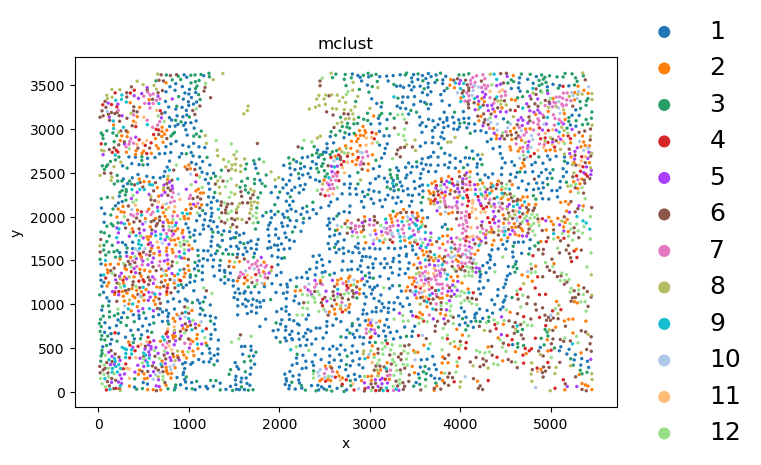

In [9]:
%matplotlib inline
coor = pd.DataFrame(adata.obsm['spatial'],columns=["x","y"],index=adata.obs_names)
adata.obs["x"]=coor["x"]
adata.obs["y"]=coor["y"]
fov_adata = adata[adata.obs['fov']==fov]
ax = sc.pl.scatter(fov_adata, alpha=1, x="x", y="y", color="mclust",  legend_fontsize=18, show=True,color_map="Blues",
                       size=100000 / fov_adata.shape[0])